In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os

In [2]:
def datestr2sec(date):
    secs = [3600,60,1]
    return sum([secs[i]*float(el) for i,el in enumerate(date.split(':'))])

Gamma:  0.7
ratio of successfull trips:  0.3917395833333333
1657.2898294260092
-------

Gamma:  1.4
ratio of successfull trips:  0.42577604166666666
1565.731373412611
-------

Gamma:  2.8
ratio of successfull trips:  0.5093125
1351.5732373335516
-------



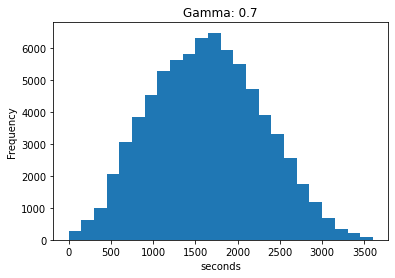

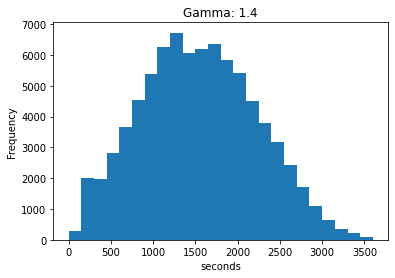

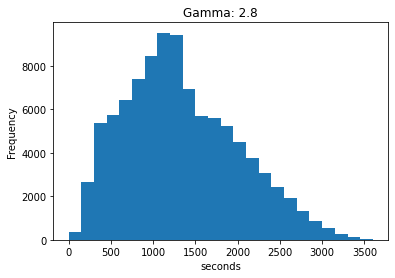

In [79]:
directory_bim = "/home/helge/Programs/matsim/matsim_results/ConvCrit/bim_twowaytransit"
directory_drt = "/home/helge/Programs/matsim/matsim_results/ConvCrit/drt/192000reqs"

def getTripTimes(directory):
    gammas = []
    trips = []
    drt_wait_times = []
    
    for root, subdirs, files in os.walk(directory):
        for file in files:
            if file == 'output_trips.csv.gz':
                request = re.match(".*gamma(\d*_\d*)", root)
                gammas.append(float(request.group(1).replace('_', '.')))
                df = pd.read_csv(os.path.join(root, file), sep=';', compression='gzip').loc[:,['person','trav_time','wait_time']]
                df['trav_time'] = df['trav_time'].apply(datestr2sec)
                df['wait_time'] = df['wait_time'].apply(datestr2sec)
                df.set_index('person', inplace=True)
                trips.append(df)
            if file == '0.drt_trips_drt.csv':
                df = pd.read_csv(os.path.join(root, file), sep=';').loc[:,['personId','waitTime']]
                drt_wait_times.append(df.groupby('personId').sum())

    return np.array(gammas), trips, drt_wait_times
 

gammas, trip_dfs, drt_wait_times = getTripTimes(directory_bim)

for i,g in enumerate(gammas):
    print('Gamma: ', g)
    print('ratio of successfull trips: ', len(trip_dfs[i])/192000)
    trip_dfs[i]['pure_trav_time'] = trip_dfs[i]['trav_time'] - trip_dfs[i]['wait_time']
    trip_dfs[i]['pure_trav_time'] = trip_dfs[i]['pure_trav_time'] + drt_wait_times[i]['waitTime']
    print(trip_dfs[i]['pure_trav_time'].mean())
    plt.figure()
    trip_dfs[i]['pure_trav_time'].plot.hist(bins=24, range=(0, 3600))
    plt.xlabel('seconds')
    plt.title('Gamma: {}'.format(g))
    print('-------\n')

plt.show()

1341.8972866869553


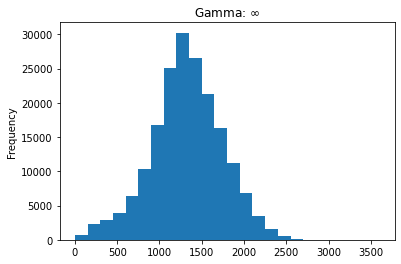

In [78]:
drt_df = pd.read_csv(os.path.join(directory_drt, 'output_trips.csv.gz'), sep=';', compression='gzip').loc[:,['person','trav_time','wait_time']]
drt_df['pure_trav_time'] = drt_df['trav_time'].apply(datestr2sec)# - drt_df['wait_time'].apply(datestr2sec)
print(drt_df['pure_trav_time'].mean())
drt_df['pure_trav_time'].plot.hist(bins=24, range=(0, 3600))
plt.title(r'Gamma: $\infty$')
plt.show()

In [6]:
datestr2sec('00:40:00')

2400.0